[Random Sampling Plot] Monte Carlo ELS Pricing
Total simulations n=10000, Fair Value = 9926.03


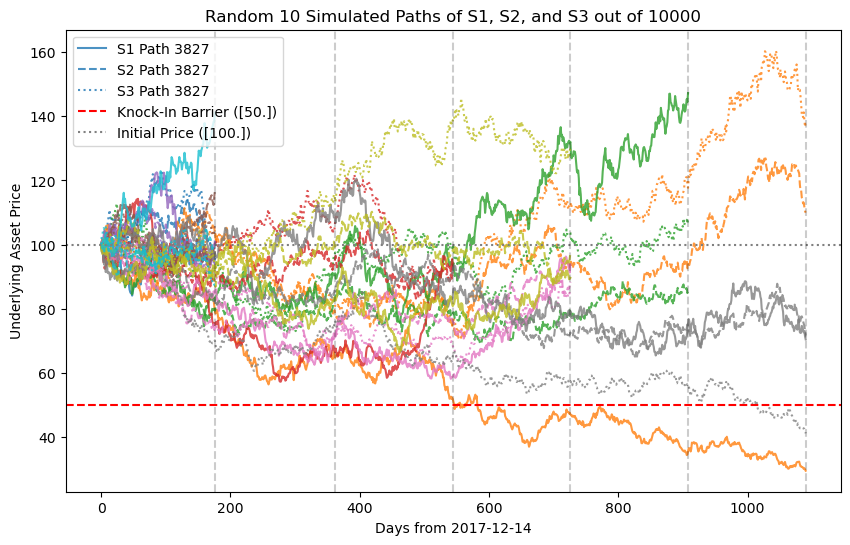


[Probability Table]
                 Event  Probability
 Redemption at Day 176       0.5616
 Redemption at Day 362       0.0895
 Redemption at Day 544       0.0708
 Redemption at Day 726       0.0358
 Redemption at Day 908       0.0343
Redemption at Day 1090       0.2080
              Knock-In       0.1148
         No Redemption       0.0752


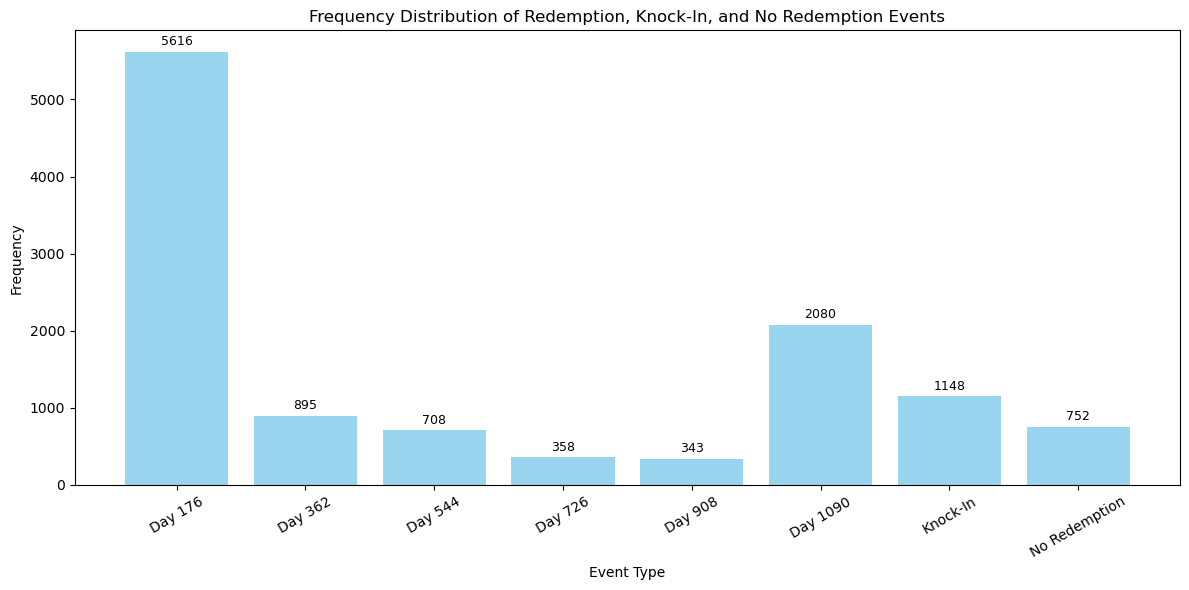

In [1]:
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as mcolors

# 시뮬레이션 파라미터
n=10000
r=0.0165
x_vol=0.2662
y_vol=0.2105
z_vol=0.2111

# 날짜 설정
n0=date.toordinal(date(2017, 12, 14))
n1=date.toordinal(date(2018, 6, 8))
n2=date.toordinal(date(2018, 12, 11))
n3=date.toordinal(date(2019, 6, 11))
n4=date.toordinal(date(2019, 12, 10))
n5=date.toordinal(date(2020, 6, 9))
n6=date.toordinal(date(2020, 12, 8))

# 조기 상환일까지의 일수
check_day=np.array([n1-n0, n2-n0, n3-n0, n4-n0, n5-n0, n6-n0])

# 자산 간 상관계수
rho_xy=0.279
rho_xz=0.2895
rho_yz=0.5256

# 상관계수 행렬
corr=[[1, rho_xy, rho_xz],\
      [rho_xy, 1, rho_yz],\
      [rho_xz, rho_yz, 1]]

# Cholesky 분해
k=np.linalg.cholesky(corr)

# 시간 파라미터
oneyear=365
tot_date=n6-n0
dt=1/oneyear

# 초기 자산 가격
S1=np.zeros((tot_date+1, 1))
S2=np.zeros((tot_date+1, 1))
S3=np.zeros((tot_date+1, 1))

S1[0]=100.0
S2[0]=100.0
S3[0]=100.0

# 초기 자산 가격 비율
ratio_S1=S1[0]
ratio_S2=S2[0]
ratio_S3=S3[0]

# 조기상환 기준
strike_price=np.array([0.90, 0.90, 0.85, 0.85, 0.80, 0.80])

# 조기상환 횟수
repay_n=len(strike_price)

# 조기상환 시 쿠폰 이자율
coupon_rate=np.array([0.048, 0.096, 0.144, 0.192, 0.24, 0.288])

# 페이오프 벡터
tot_payoff=np.zeros((repay_n, 1))
payoff=np.zeros((repay_n, 1))
discount_payoff=np.zeros((repay_n, 1))

# ELS 파라미터
face_value=10**4
kib=0.50
dummy=0.06

# 조기상환 시 페이오프 계산
payment=np.zeros((repay_n, 1))
for j in range(repay_n):
    payment[j]=face_value*(1+coupon_rate[j])

# 시뮬레이션 결과 저장
S1_all = np.zeros((n, tot_date+1))  # S1 경로 저장
S2_all = np.zeros((n, tot_date+1))  # S2 경로 저장
S3_all = np.zeros((n, tot_date+1))  # S3 경로 저장
redemption_day_all = np.full(n, -1, dtype=int)  # 조기상환 시점 저장
knock_in_events = 0  # Knock-In 발생 횟수
no_redemption_count = 0  # No Redemption 횟수

# 난수 시드 고정 (결과값 재현을 위해)
np.random.seed(42)

# 몬테카를로 시뮬레이션
for i in range(n):
    w0=np.random.normal(0, 1, size=(tot_date, 3))
    w0=np.transpose(w0)
    w=np.matmul(k, w0)
    payoff=np.zeros((repay_n, 1))
    repay_event=0
    for j in range(tot_date):
        S1[j+1]=S1[j]*np.exp((r-0.5*x_vol**2)*dt+x_vol*np.sqrt(dt)*w[0,j])
        S2[j+1]=S2[j]*np.exp((r-0.5*y_vol**2)*dt+y_vol*np.sqrt(dt)*w[1,j])
        S3[j+1]=S3[j]*np.exp((r-0.5*z_vol**2)*dt+z_vol*np.sqrt(dt)*w[2,j])
    # 모든 경로 저장
    S1_all[i] = S1.flatten()
    S2_all[i] = S2.flatten()
    S3_all[i] = S3.flatten()
    
    # Worst Performer 계산
    R1=S1/ratio_S1
    R2=S2/ratio_S2
    R3=S3/ratio_S3
    WP=np.minimum(R1, R2, R3)
    WP_checkday=WP[check_day]
    for j in range(repay_n):
        if WP_checkday[j,0] >= strike_price[j]:
            payoff[j]=payment[j]
            redemption_day_all[i] = check_day[j]  # 조기상환 시점 저장
            repay_event=1
            break
    if repay_event == 0:
        redemption_day_all[i] = check_day[-1]  # 만기 시점
        if np.min(WP) > kib:
            payoff[-1]=face_value*(1+dummy)
            no_redemption_count += 1  # No Redemption 카운트
        else:
            payoff[-1]=face_value*WP[-1]
            knock_in_events += 1  # Knock-In 발생
    tot_payoff=tot_payoff + payoff

# 평균 페이오프 계산
mean_payoff=tot_payoff/n

# 할인된 페이오프 계산
for j in range(repay_n):
    discount_payoff[j]=mean_payoff[j]*np.exp(-r*check_day[j]/oneyear)

# 최종 가격 계산
price=np.sum(discount_payoff)
print(f"[Random Sampling Plot] Monte Carlo ELS Pricing")
print(f"Total simulations n={n}, Fair Value = {price:.2f}")

# -----------------------------
# 1) 경로 시각화 (S1, S2, S3 경로를 하나의 그래프에 합침)
# -----------------------------
n_path_plot = 10  # 시각화할 경로 수 (너무 많으면 그래프가 복잡해지므로 10개로 설정)
plot_indices = np.random.choice(n, n_path_plot, replace=False)

# 색상 리스트 생성 (각 경로마다 다른 색상)
colors = list(mcolors.TABLEAU_COLORS.values())[:n_path_plot]  # Tableau 색상 팔레트 사용

plt.figure(figsize=(10,6))
alpha_line = 0.8  # 선의 투명도 조정
for idx, color in zip(plot_indices, colors):
    # S1 경로
    path_s1 = S1_all[idx]
    red_day = redemption_day_all[idx]
    path_s1_copy = path_s1.copy()
    if 0 <= red_day < len(path_s1_copy):
        path_s1_copy[red_day+1:] = np.nan
    plt.plot(path_s1_copy, color=color, alpha=alpha_line, label=f'S1 Path {idx}' if idx == plot_indices[0] else "", linestyle='-')

    # S2 경로 (같은 색상 사용, 점선으로 구분)
    path_s2 = S2_all[idx]
    path_s2_copy = path_s2.copy()
    if 0 <= red_day < len(path_s2_copy):
        path_s2_copy[red_day+1:] = np.nan
    plt.plot(path_s2_copy, color=color, alpha=alpha_line, label=f'S2 Path {idx}' if idx == plot_indices[0] else "", linestyle='--')

    # S3 경로 (같은 색상 사용, 점선+마커로 구분)
    path_s3 = S3_all[idx]
    path_s3_copy = path_s3.copy()
    if 0 <= red_day < len(path_s3_copy):
        path_s3_copy[red_day+1:] = np.nan
    plt.plot(path_s3_copy, color=color, alpha=alpha_line, label=f'S3 Path {idx}' if idx == plot_indices[0] else "", linestyle=':')

plt.axhline(y=kib*ratio_S1, color='red', linestyle='--', label=f'Knock-In Barrier ({kib*ratio_S1})')
plt.axhline(y=ratio_S1, color='gray', linestyle=':', label=f'Initial Price ({ratio_S1})')
for j in range(len(check_day)):
    plt.axvline(x=check_day[j], color='black', linestyle='--', alpha=0.2)

plt.title(f"Random {n_path_plot} Simulated Paths of S1, S2, and S3 out of {n}")
plt.xlabel("Days from 2017-12-14")
plt.ylabel("Underlying Asset Price")
plt.legend(loc='upper left')
plt.show()

# -----------------------------
# 2) 베리어별 확률 계산 및 표 출력
# -----------------------------
redemption_counts = np.zeros(len(check_day), dtype=int)
for day in redemption_day_all:
    if day in check_day:
        idx = np.where(check_day == day)[0][0]
        redemption_counts[idx] += 1

# Correct count-based probability logic
early_redemption_count = np.sum(redemption_day_all != check_day[-1])
non_redeemed_count = n - early_redemption_count

# Final probabilities
redemption_probs = redemption_counts / n
knock_in_prob = knock_in_events / n
no_redemption_prob = no_redemption_count / n

# Construct event table
data = {
    "Event": [f"Redemption at Day {check_day[i]}" for i in range(len(check_day))] + ["Knock-In", "No Redemption"],
    "Probability": list(redemption_probs) + [knock_in_prob, no_redemption_prob]
}
df = pd.DataFrame(data)
print("\n[Probability Table]")
print(df.to_string(index=False))

# -----------------------------
# 3) 도수분포표 (히스토그램) 시각화 (개선된 시각화)
# -----------------------------
all_event_counts = list(redemption_counts) + [knock_in_events, no_redemption_count]
all_event_labels = [f"Day {d}" for d in check_day] + ["Knock-In", "No Redemption"]

plt.figure(figsize=(12, 6))
bars = plt.bar(all_event_labels, all_event_counts, color='skyblue', alpha=0.85)
plt.title("Frequency Distribution of Redemption, Knock-In, and No Redemption Events")
plt.xlabel("Event Type")
plt.ylabel("Frequency")

# Add counts on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 50, f"{int(height)}", ha='center', va='bottom', fontsize=9)

plt.xticks(rotation=30)
plt.tight_layout()
plt.show()